#Importing the Data

In [ ]:
import torch
#train_data = torch.load('trainInput3BodySIMPLE.pt')
test_data= torch.load('testInput3BodySIMPLE.pt') #importing from the alternative file: 'testInput3BodySIMPLE.pt'

#Sampling the orbits

In [ ]:
#orig_inputs = train_data["inputs"]
#orig_labels = train_data["labels"]
orig_inputs = test_data["inputs"] #importing from the alternative file: 'testInput3BodySIMPLE.pt'
orig_labels = test_data["labels"] #importing from the alternative file: 'testInput3BodySIMPLE.pt'

In [ ]:
simulationNumber = len(orig_inputs)
variableNumber = orig_inputs[0].size(0) #4
truncationNumber = 200 #Input size for the neural network

max_size_orbit = max(x.size(1) for x in orig_inputs)
max_multiplication_rate = max_size_orbit // truncationNumber +1 #For pre-allocating

raw_data = torch.zeros(
    (simulationNumber * max_multiplication_rate, variableNumber, truncationNumber),
    dtype=orig_inputs[0].dtype,
    device=orig_inputs[0].device,
)
raw_labels = torch.zeros((simulationNumber*max_multiplication_rate), dtype=torch.long, device=raw_data.device)


###Check the final states (Optional)

In [ ]:
count = orig_labels.count(1)
print(count/len(orig_labels))

0.0225


#Chunking the Orbits

In [ ]:
sequence = 0
for i in range(simulationNumber):
    current_raw_input = orig_inputs[i]
    current_label = orig_labels[i]

    varNumber, orbitLength = current_raw_input.size()

    for start in range(0, orbitLength, truncationNumber):
        rest = truncationNumber #initializing
        end = start + truncationNumber
        tail = end - orbitLength
        if tail > truncationNumber // 2: #break if the tail is too long
            break
        elif tail > 0: #add a small padding
            end = orbitLength
            rest = truncationNumber - tail
        raw_data[sequence, :, :rest] = current_raw_input[:, start:end]
        raw_labels[sequence] = current_label
        sequence += 1

data = raw_data[:sequence, :, :]
labels = raw_labels[:sequence]

In [ ]:
count = (labels == 1).sum().item()
print(count/len(labels))

0.3350940904588973


###Normalizing the data

In [ ]:
#import torch
#Compute the means for the x and y positions
mean_x = 0.5 * torch.mean(data[:, 0, :]) + 0.5 * torch.mean(data[:, 2, :])
mean_y = 0.5 * torch.mean(data[:, 1, :]) + 0.5 * torch.mean(data[:, 3, :])

#Compute the max absolute value for the x positions
max_x1 = torch.max(torch.abs(data[:, 0, :]))
max_x2 = torch.max(torch.abs(data[:, 2, :]))
if max_x1 > max_x2:
    max_x = max_x1
else:
    max_x = max_x2

#Compute the max absolute value for the x positions
max_y1 = torch.max(torch.abs(data[:, 1, :]))
max_y2 = torch.max(torch.abs(data[:, 3, :]))
if max_y1 > max_y2:
    max_y = max_y1
else:
    max_y = max_y2

#Normalize the data
data[:, 0, :] = (data[:, 0, :] - mean_x) / max_x
data[:, 2, :] = (data[:, 2, :] - mean_x) / max_x

data[:, 1, :] = (data[:, 1, :] - mean_y) / max_y
data[:, 3, :] = (data[:, 3, :] - mean_y) / max_y

print(mean_x, mean_y)

tensor(0.0060, dtype=torch.float64) tensor(0.0118, dtype=torch.float64)


#Add new data using symmetries

###Define rotation transformation

In [ ]:
def rotate(tensor, angle):
    """
    tensor: any shape (?, 2, ?)
    angle: either a scalar or a tensor broadcastable to tensor[...,0]
    returns: tensor rotated by +angle
    """
    # compute cos & sin of the angle
    c = torch.cos(angle)
    s = torch.sin(angle)

    # split x,y
    x = tensor[:, 0, :]
    y = tensor[:, 1, :]

    # apply rotation formula
    x_new = x * c - y * s
    y_new = x * s + y * c

    out = tensor.clone()
    out[:, 0, :] = x_new
    out[:, 1, :] = y_new
    return out

In [ ]:
import math
simulationNumber, variableNumber, truncationNumber = data.shape

new_data = torch.zeros((simulationNumber*8*100, variableNumber, truncationNumber)) #200

#Original Data
new_data[:simulationNumber, :, :] = data

#Body Positions Switch
new_data[simulationNumber:simulationNumber*2, 0, :] = data[:, 2, :]
new_data[simulationNumber:simulationNumber*2, 1, :] = data[:, 3, :]
new_data[simulationNumber:simulationNumber*2, 2, :] = data[:, 0, :]
new_data[simulationNumber:simulationNumber*2, 3, :] = data[:, 1, :]

#x-y Switch
new_data[simulationNumber*2:simulationNumber*4, 0, :] = new_data[:simulationNumber*2, 1, :]
new_data[simulationNumber*2:simulationNumber*4, 1, :] = new_data[:simulationNumber*2, 0, :]
new_data[simulationNumber*2:simulationNumber*4, 2, :] = new_data[:simulationNumber*2, 3, :]
new_data[simulationNumber*2:simulationNumber*4, 3, :] = new_data[:simulationNumber*2, 2, :]

#reflecting over x (over y is equivalent thanks to the x-y switch)
new_data[simulationNumber*4:simulationNumber*8, 0, :] = -new_data[:simulationNumber*4, 0, :]
new_data[simulationNumber*4:simulationNumber*8, 1, :] = new_data[:simulationNumber*4, 1, :]
new_data[simulationNumber*4:simulationNumber*8, 2, :] = -new_data[:simulationNumber*4, 2, :]
new_data[simulationNumber*4:simulationNumber*8, 3, :] = new_data[:simulationNumber*4, 3, :]

#rotate:
step = 0.1  # in radians
base1 = new_data[:simulationNumber*8, :2, :].clone()
base2 = new_data[:simulationNumber*8, 2:, :].clone()
angles = torch.arange(step, 2*math.pi, step, device=new_data.device, dtype=new_data.dtype)
total_iterations = len(angles)
for i, angle in enumerate(angles):
    start = simulationNumber*8*(i+1)
    end = simulationNumber*8*(i+2)
    new_data[start:end, :2, :] = rotate(base1, angle)
    new_data[start:end, 2:, :] = rotate(base2, angle)

new_data = new_data[:simulationNumber*8*i, :, :]

new_data = new_data.permute(0, 2, 1)

In [ ]:
inputNumber, truncationNumber, variableNumber = new_data.shape
# build the index: [0,1,2,3,0,1,2,3,…] of length inputNumber
idx = torch.arange(inputNumber) % simulationNumber

new_labels = labels[idx]

print(inputNumber, variableNumber, truncationNumber)

1365424 4 200


In [ ]:
count = (new_labels == 1).sum().item()
print(count/len(new_labels))

0.3350940904588973


#Creating the Dataset

In [ ]:
!pip install deeplay deeptrack

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.3/177.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.6/195.6 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00

###Create training dataset

In [ ]:
import deeptrack as dt

train_sources_pipeline = dt.sources.Source(inputs=new_data, targets=new_labels)
train_sources, _ = dt.sources.random_split(train_sources_pipeline, [0.8, 0.2])

inputs_pipeline = dt.Value(train_sources_pipeline.inputs)
targets_pipeline = dt.Value(train_sources_pipeline.targets)

/usr/local/lib/python3.11/dist-packages/deeptrack/__init__.py:14: UserWarning: TensorFlow is detected in your environment. DeepTrack2 version 2.0++ no longer supports TensorFlow. If you need TensorFlow support, please install the legacy version 1.7 of DeepTrack2:

    pip install deeptrack==1.7

For more details, refer to the DeepTrack documentation.
  warnings.warn(


In [ ]:
from torch.utils.data import DataLoader

train_dataset = dt.pytorch.Dataset(inputs_pipeline & targets_pipeline,
                                   inputs=train_sources)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
print(len(train_loader))

36954


###Check the input dimension

In [ ]:
for in_sequences, targets in train_loader:
    print(in_sequences.shape, targets.shape)
    break

torch.Size([32, 200, 4]) torch.Size([32])


###Create the test and validation dataset

In [ ]:
import deeptrack as dt

#importing from the alternative file 'testInput3BodySIMPLE2.pt' for testing
sources_pipeline = dt.sources.Source(inputs=new_data, targets=new_labels)
test_sources, val_sources, _ = dt.sources.random_split(sources_pipeline, [0.15, 0.25, 0.6])


inputs_pipeline_test = dt.Value(sources_pipeline.inputs)
targets_pipeline_test = dt.Value(sources_pipeline.targets)

In [ ]:
from torch.utils.data import DataLoader

val_dataset = dt.pytorch.Dataset(inputs_pipeline_test & targets_pipeline_test,
                                 inputs=val_sources)
test_dataset = dt.pytorch.Dataset(inputs_pipeline_test & targets_pipeline_test,
                                   inputs=test_sources)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
print(len(val_loader), len(test_loader))

10668 6401


###Check input dimension

In [ ]:
for in_sequences, targets in val_loader:
    print(in_sequences.shape, targets.shape)
    break

torch.Size([32, 200, 4]) torch.Size([32])


#Model 1: MLP

###Create the model

In [ ]:
import deeplay as dl
drop_out = 0.4

flatten = dl.ops.Flatten(start_dim=1, end_dim=-1)
mlp_flattened = dl.MultiLayerPerceptron(
    in_features=truncationNumber*variableNumber, hidden_features=[180, 60, 30], out_features=3,
    out_activation=torch.nn.Identity
)
mlp_flattened.blocks[0].set_dropout(drop_out)
mlp_flattened.blocks[1].set_dropout(drop_out)
mlp_flattened.blocks[2].set_dropout(drop_out)
mlp = dl.Sequential(flatten, mlp_flattened)

print(mlp)

Sequential(
  (0): Flatten()
  (1): MultiLayerPerceptron(
    (blocks): LayerList(
      (0): LinearBlock(
        (layer): Layer[Linear](in_features=800, out_features=180, bias=True)
        (activation): Layer[ReLU]()
        (dropout): Layer[Dropout](p=0.4)
      )
      (1): LinearBlock(
        (layer): Layer[Linear](in_features=180, out_features=60, bias=True)
        (activation): Layer[ReLU]()
        (dropout): Layer[Dropout](p=0.4)
      )
      (2): LinearBlock(
        (layer): Layer[Linear](in_features=60, out_features=30, bias=True)
        (activation): Layer[ReLU]()
        (dropout): Layer[Dropout](p=0.4)
      )
      (3): LinearBlock(
        (layer): Layer[Linear](in_features=30, out_features=3, bias=True)
        (activation): Layer[Identity]()
      )
    )
  )
)


##Implement Custom Loss

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class WeightedPriorLoss(nn.Module):
    """
    Cross‐entropy loss reweighted by the true class priors
    """

    def __init__(self, priors: torch.Tensor):
        """
        priors: 1D tensor of length 3 with your true P(y=c) for each class c.
        """
        super().__init__()
        # ensure it’s a float tensor, not a Python list
        self.register_buffer("priors", priors.float())

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        logits: raw model outputs of shape [B, C]
        targets: integer class labels [B]
        """
        # use the priors directly as weights
        loss = F.cross_entropy(logits,
                               targets,
                               weight=self.priors,
                               reduction="mean")
        return loss

In [ ]:
true_priors = torch.tensor([0.35, 0.15, 0.5])

##Create instance of MLP

In [ ]:
mlp_classifier = dl.Classifier(
    model=mlp, num_classes=3, make_targets_one_hot=True,
    optimizer=dl.Adam(lr=0.001), loss=WeightedPriorLoss(priors=true_priors)
).create()

print(mlp_classifier)

Classifier(
  (loss): WeightedPriorLoss()
  (optimizer): Adam[Adam](lr=0.001)
  (train_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=test
  )
  (model): Sequential(
    (0): Flatten()
    (1): MultiLayerPerceptron(
      (blocks): LayerList(
        (0): LinearBlock(
          (layer): Linear(in_features=800, out_features=180, bias=True)
          (activation): ReLU()
          (dropout): Dropout(p=0.4, inplace=False)
        )
        (1): LinearBlock(
          (layer): Linear(in_features=180, out_features=60, bias=True)
          (activation): ReLU()
          (dropout): Dropout(p=0.4, inplace=False)
        )
        (2): LinearBlock(
          (layer): Linear(in_features=60, out_features=30, bias=True)
          (activation): ReLU()
    

###Train and Validate the model

In [ ]:
epochs = 6
mlp_trainer = dl.Trainer(max_epochs=epochs, accelerator="auto")
mlp_trainer.fit(mlp_classifier, train_loader, val_loader)

INFO: 
  | Name          | Type              | Params | Mode 
------------------------------------------------------------
0 | loss          | WeightedPriorLoss | 0      | train
1 | train_metrics | MetricCollection  | 0      | train
2 | val_metrics   | MetricCollection  | 0      | train
3 | test_metrics  | MetricCollection  | 0      | train
4 | model         | Sequential        | 156 K  | train
5 | optimizer     | Adam              | 0      | train
------------------------------------------------------------
156 K     Trainable params
0         Non-trainable params
156 K     Total params
0.628     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type              | Params | Mode 
------------------------------------------------------------
0 | loss          | WeightedPriorLoss | 0      | train
1 | train_metrics | MetricCollection  | 0      | train
2 | val_metrics   |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

###Define the training and validation losses

In [ ]:
train_losses = mlp_trainer.history.history["train_loss_epoch"]["value"]
val_losses = mlp_trainer.history.history["val_loss_epoch"]["value"][1:]

###Define the test loss

In [ ]:
import torch.nn as nn
import math
criterion = nn.CrossEntropyLoss()

test_loss = 0.0
mlp_classifier.eval()
with torch.no_grad():
    for in_sequences, targets in test_loader:
        y_pred = mlp_classifier(in_sequences)

        loss = criterion(y_pred, targets)
        test_loss += loss.item()
    test_loss /= len(test_loader)
    probabilityConfidence = math.exp(-test_loss)
    print(f"test Loss: {test_loss:.4f}")
    print(f"Probability Confidence: {probabilityConfidence:.4f}")

test Loss: 0.3285
Probability Confidence: 0.7200


##Define accuracy

In [ ]:
import torch

num_classes = 3

# To track per‐class accuracy:
correct_per_class = {cls: 0 for cls in range(num_classes)}
total_per_class   = {cls: 0 for cls in range(num_classes)}

# To track overall accuracy:
correct = 0
total   = 0

mlp_classifier.eval()
with torch.no_grad():
    for in_sequences, targets in test_loader:
        # 1) Forward pass
        logits = mlp_classifier(in_sequences)          # shape: [batch_size, num_classes]

        # 2) Predicted class indices
        preds = logits.argmax(dim=1)                   # shape: [batch_size]

        # 3) Overall correct / total
        correct += (preds == targets).sum().item()
        total   += targets.size(0)

        # 4) Per‐class correct / total
        for cls in range(num_classes):
            cls_mask = (targets == cls)                # which samples are truly class `cls`
            total_per_class[cls]   += cls_mask.sum().item()
            correct_per_class[cls] += (preds[cls_mask] == cls).sum().item()

# 5) Compute and print
overall_acc = correct / total
print(f"Overall accuracy: {overall_acc:.4f}")

for cls in range(num_classes):
    if total_per_class[cls] > 0:
        acc = correct_per_class[cls] / total_per_class[cls]
        print(f"Class {cls} accuracy: {acc:.4f} ({correct_per_class[cls]}/{total_per_class[cls]})")
    else:
        print(f"Class {cls} has no examples in the test set.")

Overall accuracy: 0.8628
Class 0 accuracy: 0.8500 (38888/45752)
Class 1 accuracy: 0.7888 (15514/19667)
Class 2 accuracy: 0.8775 (122317/139395)


###Define the test loss per class (Optional)

In [ ]:
criterion = nn.CrossEntropyLoss(reduction='none')

num_classes = 3

total_loss = { cls: 0.0 for cls in range(num_classes) }
counts     = { cls: 0   for cls in range(num_classes) }

mlp_classifier.eval()
with torch.no_grad():
    for in_sequences, targets in test_loader:
        y_pred = mlp_classifier(in_sequences)
        losses = criterion(y_pred, targets)   # shape [B]

        # for each possible class, pick out the examples in this batch
        for cls in range(num_classes):
            mask = (targets == cls)           # boolean mask, shape [B]
            if mask.any():
                total_loss[cls] += losses[mask].sum().item()
                counts[cls]     += mask.sum().item()

# finally compute the avg loss per class
avg_loss_per_class = {
    cls: total_loss[cls] / counts[cls]
    if counts[cls] > 0 else float('nan')
    for cls in range(num_classes)
}

for cls, avg in avg_loss_per_class.items():
    print(f"Class {cls:2d} — avg loss = {avg:.4f} (n={counts[cls]})")

Class  0 — avg loss = 0.4293 (n=45752)
Class  1 — avg loss = 0.6271 (n=19667)
Class  2 — avg loss = 0.2532 (n=139395)


###Plot the losses

In [ ]:
from matplotlib import pyplot as plt
def plot_training(epochs, train_losses, val_losses, bench_loss):
    """Plot the training and validation losses."""
    plt.plot(range(epochs), train_losses, label="Training Loss")
    plt.plot(range(epochs), val_losses, "--", label="Validation Loss")

    plt.xlabel("Epoch")
    plt.xlim([0, epochs - 1])
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [ ]:
plot_training(epochs, train_losses, val_losses, test_loss)

NameError: name 'plot_training' is not defined

#Model 2: GRU with attention

###Create the model

In [ ]:
import torch
import torch.nn as nn

class StackedGRU(nn.Module):
    def __init__(self, input_size, hidden_features, out_features, attn_dim, dropout=0.2):
        super().__init__()
        self.featuresNumber = attn_dim
        self.layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        for i, hidden in enumerate(hidden_features):
            in_feats = input_size if i == 0 else hidden_features[i-1]
            # each layer is its own GRU
            self.layers.append(
                nn.GRU(
                    input_size=in_feats,
                    hidden_size=hidden,
                    batch_first=True
                )
            )
            # dropout
            self.dropouts.append(nn.Dropout(dropout))

        self.Wq   = nn.Linear(input_size, attn_dim)
        self.Wk   = nn.Linear(hidden_features[-1], attn_dim)
        self.Wv   = nn.Linear(hidden_features[-1], attn_dim)
        self.Wout = nn.Linear(attn_dim, attn_dim)

        # map from last layer’s hidden size to final output
        self.fc = nn.Linear(attn_dim, out_features)

    def forward(self, x, return_attn: bool = False):
        # x: (batch, seq_len, input_size)
        y = x.clone()
        for gru, do in zip(self.layers, self.dropouts):
            y, _ = gru(y)    # x now (batch, seq_len, hidden_i)
            y = do(y)

        y_query = self.Wq(x)
        y_key = self.Wk(y)
        y_value = self.Wv(y)


        attn_scores = (torch.matmul(y_query, y_key.transpose(-2, -1))
                       / ( self.featuresNumber** 0.5))
        attn_weights = torch.nn.functional.softmax(attn_scores, dim=-1)
        y = torch.matmul(attn_weights, y_value)
        y = self.Wout(y)

        # take last time‑step
        last = y[:, -1, :]

        if return_attn:
            return self.fc(last), attn_weights
        else:
            return self.fc(last)

In [ ]:
feature_length = variableNumber #4
gru_model = StackedGRU(
    input_size=feature_length,
    hidden_features=[4, 4],
    out_features=3,
    attn_dim=3,
    dropout=0.3
)

##Train the second model

In [ ]:
true_priors = torch.tensor([0.38, 0.13, 0.5])

In [ ]:
optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.001)
criterion = WeightedPriorLoss(priors=true_priors)
epochs = 10

train_losses, val_losses = [], []
for epoch in range(epochs):
    train_loss = 0.0
    for in_sequences, targets in train_loader:
        optimizer.zero_grad()

        y_pred = gru_model(in_sequences)
        loss = criterion(y_pred, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))
    print(f"Epoch {epoch} Training Loss: {train_losses[-1]:.4f}")

    val_loss = 0.0
    with torch.no_grad():
        for in_sequences, targets in val_loader:
            y_pred = gru_model(in_sequences)

            loss = criterion(y_pred, targets)
            val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        print(f"Epoch {epoch} Validation Loss: {val_losses[-1]:.4f}")

Epoch 0 Training Loss: 0.6951
Epoch 0 Validation Loss: 0.5271
Epoch 1 Training Loss: 0.5777
Epoch 1 Validation Loss: 0.4855
Epoch 2 Training Loss: 0.5361
Epoch 2 Validation Loss: 0.4263
Epoch 3 Training Loss: 0.5277
Epoch 3 Validation Loss: 0.4172
Epoch 4 Training Loss: 0.5132
Epoch 4 Validation Loss: 0.4134
Epoch 5 Training Loss: 0.5061
Epoch 5 Validation Loss: 0.3933
Epoch 6 Training Loss: 0.5092
Epoch 6 Validation Loss: 0.4072
Epoch 7 Training Loss: 0.4893
Epoch 7 Validation Loss: 0.3736
Epoch 8 Training Loss: 0.4815
Epoch 8 Validation Loss: 0.4097
Epoch 9 Training Loss: 0.4797
Epoch 9 Validation Loss: 0.3914


##Define test loss

In [ ]:
import torch.nn as nn
import math
criterion = nn.CrossEntropyLoss()

test_loss = 0.0
gru_model.eval()
with torch.no_grad():
    for in_sequences, targets in test_loader:
        y_pred = gru_model(in_sequences)

        loss = criterion(y_pred, targets)
        test_loss += loss.item()
    test_loss /= len(test_loader)
    probabilityConfidence = math.exp(-test_loss)
    print(f"test Loss: {test_loss:.4f}")
    print(f"Probability Confidence: {probabilityConfidence:.4f}")

test Loss: 1.1765
Probability Confidence: 0.3084


##Define Accuracy

In [ ]:
import torch

num_classes = 3

# To track per‐class accuracy:
correct_per_class = {cls: 0 for cls in range(num_classes)}
total_per_class   = {cls: 0 for cls in range(num_classes)}

# To track overall accuracy:
correct = 0
total   = 0

gru_model.eval()
with torch.no_grad():
    for in_sequences, targets in test_loader:
        # 1) Forward pass
        logits = gru_model(in_sequences)          # shape: [batch_size, num_classes]

        # 2) Predicted class indices
        preds = logits.argmax(dim=1)                   # shape: [batch_size]

        # 3) Overall correct / total
        correct += (preds == targets).sum().item()
        total   += targets.size(0)

        # 4) Per‐class correct / total
        for cls in range(num_classes):
            cls_mask = (targets == cls)                # which samples are truly class `cls`
            total_per_class[cls]   += cls_mask.sum().item()
            correct_per_class[cls] += (preds[cls_mask] == cls).sum().item()

# 5) Compute and print
overall_acc = correct / total
print(f"Overall accuracy: {overall_acc:.4f}")

for cls in range(num_classes):
    if total_per_class[cls] > 0:
        acc = correct_per_class[cls] / total_per_class[cls]
        print(f"Class {cls} accuracy: {acc:.4f} ({correct_per_class[cls]}/{total_per_class[cls]})")
    else:
        print(f"Class {cls} has no examples in the test set.")

Overall accuracy: 0.6742
Class 0 accuracy: 0.0000 (0/45960)
Class 1 accuracy: 0.0461 (917/19870)
Class 2 accuracy: 0.9870 (137178/138984)


##Define losses per class (Optional)

In [ ]:
criterion = nn.CrossEntropyLoss(reduction='none')

num_classes = 3

total_loss = { cls: 0.0 for cls in range(num_classes) }
counts     = { cls: 0   for cls in range(num_classes) }

gru_model.eval()
with torch.no_grad():
    for in_sequences, targets in test_loader:
        y_pred = gru_model(in_sequences)
        losses = criterion(y_pred, targets)   # shape [B]

        # for each possible class, pick out the examples in this batch
        for cls in range(num_classes):
            mask = (targets == cls)           # boolean mask, shape [B]
            if mask.any():
                total_loss[cls] += losses[mask].sum().item()
                counts[cls]     += mask.sum().item()

# finally compute the avg loss per class
avg_loss_per_class = {
    cls: total_loss[cls] / counts[cls]
    if counts[cls] > 0 else float('nan')
    for cls in range(num_classes)
}

for cls, avg in avg_loss_per_class.items():
    print(f"Class {cls:2d} — avg loss = {avg:.4f} (n={counts[cls]})")

##Plot attention Matrix

In [ ]:
gru_model.eval()
batch_of_inputs = next(iter(test_loader))[0]
with torch.no_grad():
    features, attn_matrix = gru_model(batch_of_inputs, return_attn=True)
attn_matrix = attn_matrix[0]

In [ ]:
print(attn_matrix.shape)

torch.Size([200, 200])


In [ ]:
from matplotlib import pyplot as plt
from matplotlib.ticker import FixedLocator

def plot_attention(attn_matrix):
    """Plot attention."""
    yLength, xLength = attn_matrix.shape
    fig, ax = plt.subplots()
    cax = ax.matshow(attn_matrix, cmap="Greens")
    fig.colorbar(cax)
    plt.show()

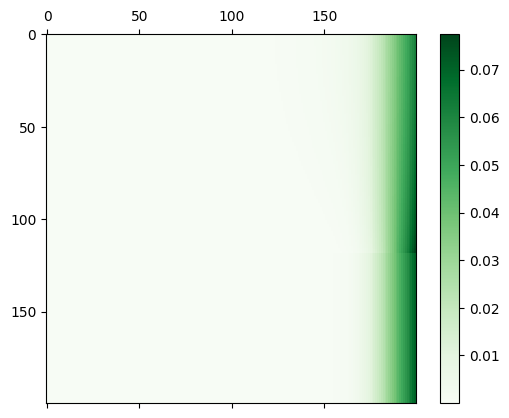

In [ ]:
plot_attention(attn_matrix)

##Plot the losses

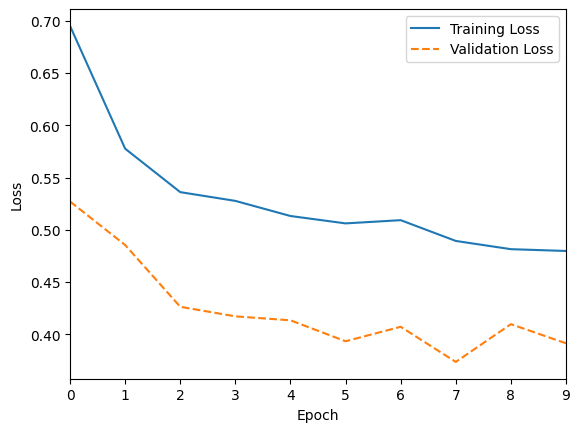

In [ ]:
plot_training(epochs, train_losses, val_losses, test_loss)

#Model 3: Transformer

##Define the Transformer

In [ ]:
import deeplay as dl

class MultiHeadAttentionLayer(dl.DeeplayModule):
    """Multi-head attention layer with masking."""

    def __init__(self, num_features, num_heads):
        """Initialize multi-head attention."""
        super().__init__()
        self.num_features, self.num_heads = num_features, num_heads
        self.head_dim = num_features // num_heads  # Must be integer

        self.Wq = dl.Layer(torch.nn.Linear, num_features, num_features)
        self.Wk = dl.Layer(torch.nn.Linear, num_features, num_features)
        self.Wv = dl.Layer(torch.nn.Linear, num_features, num_features)
        self.Wout = dl.Layer(torch.nn.Linear, num_features, num_features)

    def forward(self, in_sequence):
        """Apply the multi-head attention mechanism to the input sequence."""
        batch_size, seq_len, embed_dim = in_sequence.shape
        Q = self.Wq(in_sequence)
        Q = Q.view( batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        K = self.Wk(in_sequence)
        K = K.view( batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        V = self.Wv(in_sequence)
        V = V.view( batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        attn_scores = (torch.matmul(Q, K.transpose(-2, -1))
                       / (self.head_dim ** 0.5))

        attn_weights = torch.nn.functional.softmax(attn_scores, dim=-1)
        attn_output = torch.matmul(attn_weights, V)

        attn_output = attn_output.permute(0, 2, 1, 3).contiguous()
        attn_output = attn_output.view(batch_size, seq_len, self.num_features)
        return self.Wout(attn_output)

In [ ]:
from torch_geometric.nn.norm import LayerNorm

class TransformerEncoderLayer(dl.DeeplayModule):
    """Transformer encoder layer."""

    def __init__(self, num_features, num_heads, feedforward_dim, dropout=0.0):
        """Initialize transformer encoder layer."""
        super().__init__()

        self.self_attn = MultiHeadAttentionLayer(num_features, num_heads)
        self.attn_dropout = dl.Layer(torch.nn.Dropout, dropout)
        self.attn_skip = dl.Add()
        self.attn_norm = dl.Layer(LayerNorm, num_features, eps=1e-6)

        self.feedforward = dl.Sequential(
            dl.Layer(torch.nn.Linear, num_features, feedforward_dim),
            dl.Layer(torch.nn.ReLU),
            dl.Layer(torch.nn.Linear, feedforward_dim, num_features),
        )
        self.feedforward_dropout = dl.Layer(torch.nn.Dropout, dropout)
        self.feedforward_skip = dl.Add()
        self.feedforward_norm = dl.Layer(LayerNorm, num_features, eps=1e-6)

    def forward(self, in_sequence):
        """Refine sequence via attention and feedforward layers."""
        attns = self.self_attn(in_sequence)
        attns = self.attn_dropout(attns)
        attns = self.attn_skip(in_sequence, attns)
        attns = self.attn_norm(attns)

        out_sequence = self.feedforward(attns)
        out_sequence = self.feedforward_dropout(out_sequence)
        out_sequence = self.feedforward_skip(attns, out_sequence)
        out_sequence = self.feedforward_norm(out_sequence)

        return out_sequence

In [ ]:
import math
class PositionalEncoding(torch.nn.Module):
    """Positional encodings"""
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1) # [max_len, 1]
        #denominators for even and odd indices
        div_term = torch.exp(
            torch.arange(0, d_model, 1, dtype=torch.float32) *
            -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term[0::2])
        pe[:, 1::2] = torch.cos(position * div_term[1::2])
        #store it so, it moves with .to(device)
        self.register_buffer('pe', pe.unsqueeze(0))  # shape: [1 x max_len x d_model]
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len, d_model = x.size()
        return x + self.pe[:, :seq_len, :]

In [ ]:
class TransformerEncoderModel(dl.DeeplayModule):
    """Transformer encoder model."""

    def __init__(self, input_size, sequence_length, num_features, num_heads, feedforward_dim,
                 num_layers, out_dim, dropout=0.0):
        """Initialize transformer encoder model."""
        super().__init__()
        self.num_features = num_features

        self.embedding = dl.Layer(torch.nn.Linear, input_size, num_features) #Changed the embedding to accept real number

        self.pos_encoder = dl.Layer(PositionalEncoding, num_features, sequence_length)

        self.transformer_block = dl.LayerList()
        for _ in range(num_layers):
            self.transformer_block.append(TransformerEncoderLayer(
                    num_features, num_heads, feedforward_dim, dropout=dropout,
            ))

        self.out_block = dl.Sequential(
            dl.Layer(torch.nn.Dropout, dropout),
            dl.Layer(torch.nn.Linear, num_features, num_features // 2),
            dl.Layer(torch.nn.ReLU),
            dl.Layer(torch.nn.Linear, num_features // 2, out_dim),
        )


    def forward(self, input):
        """Predict sentiment of movie reviews."""
        in_sequence = input
        embeddings = self.embedding(in_sequence) * self.num_features ** 0.5
        pos_embeddings = self.pos_encoder(embeddings)

        out_sequence = pos_embeddings
        for transformer_layer in self.transformer_block:
            out_sequence = transformer_layer(out_sequence)

        final_sequence = self.out_block(out_sequence).squeeze()
        final_states = final_sequence[:, -1, :]
        return final_states

In [ ]:
number_channels = variableNumber #4
seq_len = truncationNumber #200
transformer_encoder = TransformerEncoderModel(
    input_size= number_channels, sequence_length = seq_len,
    num_features=12, num_heads=3, feedforward_dim=20,
    num_layers=2, out_dim=3, dropout=0.3,
).create()

In [ ]:
print(transformer_encoder)

TransformerEncoderModel(
  (embedding): Linear(in_features=4, out_features=12, bias=True)
  (pos_encoder): PositionalEncoding()
  (transformer_block): LayerList(
    (0-1): 2 x TransformerEncoderLayer(
      (self_attn): MultiHeadAttentionLayer(
        (Wq): Linear(in_features=12, out_features=12, bias=True)
        (Wk): Linear(in_features=12, out_features=12, bias=True)
        (Wv): Linear(in_features=12, out_features=12, bias=True)
        (Wout): Linear(in_features=12, out_features=12, bias=True)
      )
      (attn_dropout): Dropout(p=0.3, inplace=False)
      (attn_skip): Add()
      (attn_norm): LayerNorm(12, affine=True, mode=graph)
      (feedforward): Sequential(
        (0): Linear(in_features=12, out_features=20, bias=True)
        (1): ReLU()
        (2): Linear(in_features=20, out_features=12, bias=True)
      )
      (feedforward_dropout): Dropout(p=0.3, inplace=False)
      (feedforward_skip): Add()
      (feedforward_norm): LayerNorm(12, affine=True, mode=graph)
    

##Train the third Model

In [ ]:
transformer_model = dl.Classifier(transformer_encoder, num_classes=3,
                                  make_targets_one_hot=True,
                                  optimizer=dl.Adam(lr=0.001),
                                  loss=WeightedPriorLoss(priors=true_priors)).create()

##Plot the losses

In [ ]:
epochs = 1
trainer = dl.Trainer(max_epochs=epochs, accelerator="auto")
trainer.fit(transformer_model, train_loader, val_loader)

INFO: 
  | Name          | Type                    | Params | Mode 
------------------------------------------------------------------
0 | loss          | WeightedPriorLoss       | 0      | train
1 | train_metrics | MetricCollection        | 0      | train
2 | val_metrics   | MetricCollection        | 0      | train
3 | test_metrics  | MetricCollection        | 0      | train
4 | model         | TransformerEncoderModel | 2.5 K  | train
5 | optimizer     | Adam                    | 0      | train
------------------------------------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)
49        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type                    | Params | Mode 
------------------------------------------------------------------
0 | loss          | WeightedPriorLoss       | 0      | train
1 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

##Plot Losses

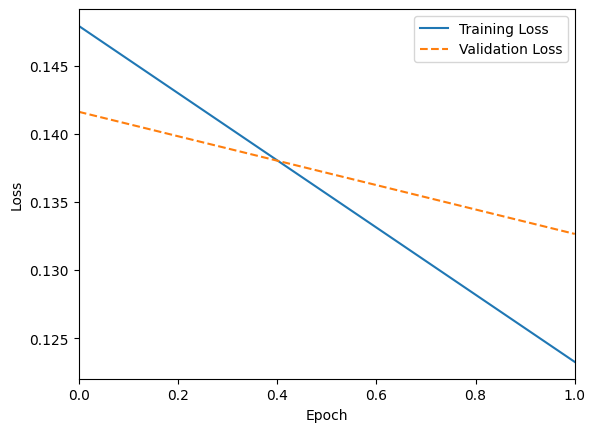

In [ ]:
train_losses = trainer.history.history["train_loss_epoch"]["value"]
val_losses = trainer.history.history["val_loss_epoch"]["value"][1:]
bench_loss=0
plot_training(epochs, train_losses, val_losses, bench_loss)

##Define test loss

In [ ]:
import torch.nn as nn
import math
criterion = nn.CrossEntropyLoss()
#criterion = WeightedPriorLoss(priors=true_priors)

test_loss = 0.0
transformer_model.eval()
with torch.no_grad():
    for in_sequences, targets in test_loader:
        y_pred = transformer_model(in_sequences)

        loss = criterion(y_pred, targets)
        test_loss += loss.item()
    test_loss /= len(test_loader)
    probabilityConfidence = math.exp(-test_loss)
    print(f"test Loss: {test_loss:.4f}")
    print(f"Probability Confidence: {probabilityConfidence:.4f}")

test Loss: 0.3386
Probability Confidence: 0.7128


##Define Accuracy

In [ ]:
import torch

num_classes = 3

# To track per‐class accuracy:
correct_per_class = {cls: 0 for cls in range(num_classes)}
total_per_class   = {cls: 0 for cls in range(num_classes)}

# To track overall accuracy:
correct = 0
total   = 0

transformer_model.eval()
with torch.no_grad():
    for in_sequences, targets in test_loader:
        # 1) Forward pass
        logits = transformer_model(in_sequences)          # shape: [batch_size, num_classes]

        # 2) Predicted class indices
        preds = logits.argmax(dim=1)                   # shape: [batch_size]

        # 3) Overall correct / total
        correct += (preds == targets).sum().item()
        total   += targets.size(0)

        # 4) Per‐class correct / total
        for cls in range(num_classes):
            cls_mask = (targets == cls)                # which samples are truly class `cls`
            total_per_class[cls]   += cls_mask.sum().item()
            correct_per_class[cls] += (preds[cls_mask] == cls).sum().item()

# 5) Compute and print
overall_acc = correct / total
print(f"Overall accuracy: {overall_acc:.4f}")

for cls in range(num_classes):
    if total_per_class[cls] > 0:
        acc = correct_per_class[cls] / total_per_class[cls]
        print(f"Class {cls} accuracy: {acc:.4f} ({correct_per_class[cls]}/{total_per_class[cls]})")
    else:
        print(f"Class {cls} has no examples in the test set.")

Overall accuracy: 0.8424
Class 0 accuracy: 0.8952 (41120/45932)
Class 1 accuracy: 0.6482 (12756/19679)
Class 2 accuracy: 0.8524 (118658/139203)


##Define losses per class (Optional)

In [ ]:
criterion = nn.CrossEntropyLoss(reduction='none')

num_classes = 3

total_loss = { cls: 0.0 for cls in range(num_classes) }
counts     = { cls: 0   for cls in range(num_classes) }

transformer_model.eval()
with torch.no_grad():
    for in_sequences, targets in test_loader:
        y_pred = transformer_model(in_sequences)
        losses = criterion(y_pred, targets)   # shape [B]

        # for each possible class, pick out the examples in this batch
        for cls in range(num_classes):
            mask = (targets == cls)           # boolean mask, shape [B]
            if mask.any():
                total_loss[cls] += losses[mask].sum().item()
                counts[cls]     += mask.sum().item()

# finally compute the avg loss per class
avg_loss_per_class = {
    cls: total_loss[cls] / counts[cls]
    if counts[cls] > 0 else float('nan')
    for cls in range(num_classes)
}

for cls, avg in avg_loss_per_class.items():
    print(f"Class {cls:2d} — avg loss = {avg:.4f} (n={counts[cls]})")